# 1. The Lagrange Multiplier test


The LM test examines whether the scores from the restricted model are 0. If the null is true, and the restrictions are valid, then the parameters of the restricted model should be close to the minimum of the sum of squared errors, and so the scores should be close to zero, on average.

Full model: $$ Y=X_1+X_2+u$$
Restricted model: $$ Y=X_1+u$$

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2
import statsmodels.api as sm
import pysal as ps
import matplotlib.pyplot as plt
from spatial_functions import sarerror_complete, sarlag_complete
from pysal.model import spreg

In [2]:
# Generate some data
np.random.seed(12)
x1, x2, x3 = np.random.normal(size=(3,100))

#Generate Y
y =  x1 + x2+ np.random.normal(size=100)

# Fit two models
model = sm.OLS(y, np.column_stack((x1, x2))).fit() #Full model
model1 = sm.OLS(y, x1).fit() #Restricted model


#LM statistic using the package s
LM, P_value, df_diff=model.compare_lm_test(model1)


#The test is simply n*R^2, where R^2 come from an auxiliary regression: Regress the residuals of the restricted model on the covariates
Y=model1.resid
aux_reg=sm.OLS(Y,np.column_stack((x1, x2))).fit()
lm=100*aux_reg.rsquared

#p-value manual
df=model1.df_resid-model.df_resid
pvalue=stats.chi2.sf(lm,df )

print('LM_manual', round(lm,4))
print('LM_package:', round(LM,4))
print('P-value_MANUAL:', pvalue)
print('P-value_PACKAGE:', P_value)

LM_manual 62.6747
LM_package: 62.6747
P-value_MANUAL: 2.438228896512582e-15
P-value_PACKAGE: 2.4382288965125907e-15


The null hypothesis was rejected.  
A formal proof of this result can be found [here](https://stats.stackexchange.com/q/570201)

In fact, $X_2$ is included in the DGP, so restrict the model is not valid.   
However, if we include the variable $X_3$, which is not part of the DGP of $Y$, the result should be different: 

In [3]:
model2= sm.OLS(y, np.column_stack((x1, x2,x3))).fit() #Full model
LM, P_value, df_diff=model2.compare_lm_test(model)

print('LM:', round(LM,4))
print('P-value:', round(P_value,4))

LM: 0.0744
P-value: 0.7851


# 2 LM in Spatial Regression

- In spatial regression models the usual LM tests [(Anselin et. al, 1996)](https://www.sciencedirect.com/science/article/pii/0166046295021116) are modified versions and can be used as diagnostic tests.
- One advantage is that they do not require the estimation of the spatial model, just the spatial weights matrix is needed.


## 2.1 Classic Lagrange Multiplier test (Anselin et. al, 1996)

In [4]:
# Create A spatial weights matrix for a grid with 100 observations
n=10
w = ps.lib.weights.lat2W(n,n) # Rook matrix for a nxn grid
w.transform = 'r' #Row-standardize it

In [5]:
# Generate some data for 100 observations
np.random.seed(1234)
x1, x2, x3 = [np.random.normal(size=(100, 1)) for i in range(3)]
X=np.column_stack((x1, 3*x2,2*x3))
#Generate Y
Y =  x1 + 3*x2+2*x3 +np.random.normal(size=(100, 1))
#estimate OLS
ols=spreg.OLS(Y,X)

#Run the tests
lm=spreg.LMtests(ols,w=w)

#Print the results
print('LM-lag statistic:',round(lm.lml[0] ,4))
print('LM-lag p-value:',round(lm.lml[1],4) )
print('LM-Error statistic:',round(lm.lme[0] ,4))
print('LM-Error p-value:',round(lm.lme[1] ,4))

LM-lag statistic: 0.1148
LM-lag p-value: 0.7348
LM-Error statistic: 0.0123
LM-Error p-value: 0.9118


For both tests the Null Hypothesis is that the true model is the "OLS model" (no spatial autocorrelation).   
Given the results, we do not reject the null.

### 2.1.1 Simulation to test the empirical size of LM tests

In [6]:
reps=5000
reject_error=np.zeros(reps)
reject_lag=np.zeros(reps)

for i in range(reps):
    x1, x2 = [np.random.normal(size=(100, 1)) for i in range(2)]
    X=np.column_stack((x1, 3*x2))
    #Generate Y
    Y =  x1 + 3*x2 +np.random.normal(size=(100, 1), scale=3)
    #estimate OLS
    ols=spreg.OLS(Y,X)
    #Run the tests
    lm=spreg.LMtests(ols,w=w)
    reject_error[i]=lm.lme[1]
    reject_lag[i]=lm.lml[1]
size_lag=len(np.where(reject_lag<0.05)[0])/reps
size_error=len(np.where(reject_error<0.05)[0])/reps
print('The empirical size of LM-Lag is:',size_lag)
print('The empirical size of LM-Error is:',size_error)

The empirical size of LM-Lag is: 0.0492
The empirical size of LM-Error is: 0.046


- For both tests, setting the critical p-value as 0.05, the null hypothesis was (falsely) rejected around 5% of the times, as expected.

### 2.1.2 Simulation to test the power of LM tests

- To test the power of LM test, we change the value of $\rho$ and check the power curve

In [7]:
#LM-Error
reps=1000
list_rho=np.arange(0,1,.05)
size_error=np.zeros(len(list_rho))
for j in range(len(list_rho)):
    reject=np.zeros(reps)
    for i in range(reps):
        y1,x1,v1=sarerror_complete(w, rho=list_rho[j])
        ols=spreg.OLS(y1,x1)
        lm=spreg.LMtests(ols,w=w)
        reject[i]=lm.lme[1]
    size_error[j]=len(np.where(reject<0.05)[0])/reps

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


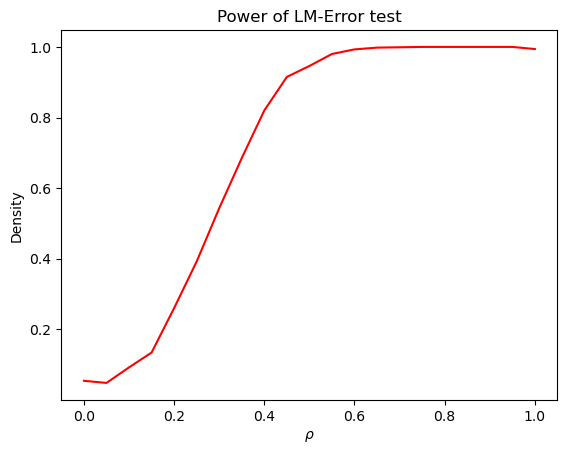

In [8]:
plt.plot(list_rho,size_error, color='red')
plt.xlabel(r'$\rho$')
plt.ylabel('Density')
plt.title ('Power of LM-Error test');

In [9]:
#LM-Lag
reps=1000
list_rho=np.arange(0,1,.05)
size=np.zeros(len(list_rho))
for j in range(len(list_rho)):
    reject=np.zeros(reps)
    for i in range(reps):
        y1,x1,v1=sarlag_complete(w, rho=list_rho[j])
        ols=spreg.OLS(y1,x1)
        lm=spreg.LMtests(ols,w=w)
        reject[i]=lm.lme[1]
    size[j]=len(np.where(reject<0.05)[0])/reps

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001


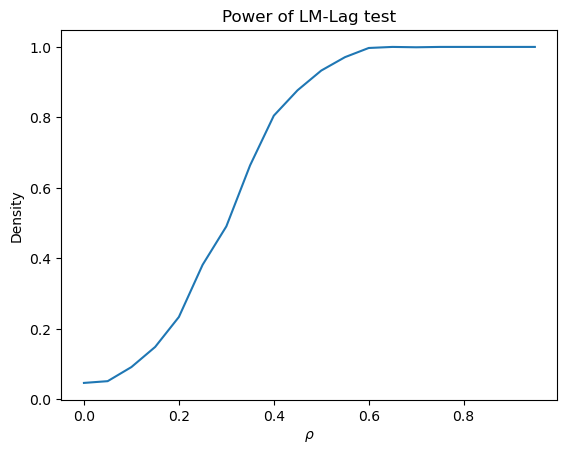

In [10]:
plt.plot(list_rho,size)
plt.xlabel(r'$\rho$')
plt.ylabel('Density')
plt.title ('Power of LM-Lag test');

- One drawback of these tests is that they can not be computed as $n*R^2$!
- For this reason, [Born & Breitung (2011)](https://www.jstor.org/stable/23118082) propose an alternative version that can be computed using an auxiliary regression. Moreover, the authors claim their test is robust against heteroscedastic errors.

## 2.2 The alternative version from Born and Breitung